## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers


In [4]:
# Importing the libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [5]:
# Importing the torch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, utils

In [7]:
# Defining the Net in models.py and instantiate it
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=36864, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
  (drop1): Dropout(p=0.1)
  (drop2): Dropout(p=0.2)
  (drop3): Dropout(p=0.3)
  (drop4): Dropout(p=0.4)
  (drop5): Dropout(p=0.5)
  (drop6): Dropout(p=0.6)
)


In [6]:
# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset

# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


# defining the data transform (order matters! i.e. rescaling should come before a smaller crop)
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [9]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [10]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


In [11]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [12]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

In [13]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

In [14]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints


In [15]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


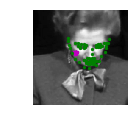

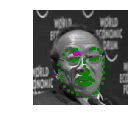

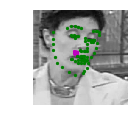

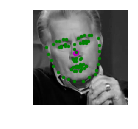

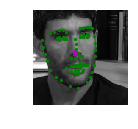

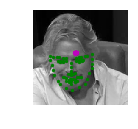

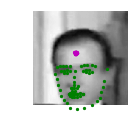

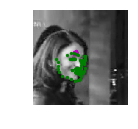

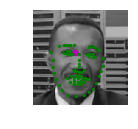

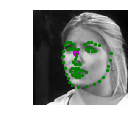

In [16]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

In [17]:
# loss and optimization
criterion = nn.MSELoss()

optimizer = optim.Adam(params = net.parameters(), lr = 0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [18]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0
    return running_loss
    print('Finished Training')


In [22]:
# train your network
n_epochs = 8 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    total_loss = train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.005308682441711426
Epoch: 1, Batch: 20, Avg. Loss: 0.0026404662877321243
Epoch: 1, Batch: 30, Avg. Loss: 0.002168671041727066
Epoch: 1, Batch: 40, Avg. Loss: 0.0021258774176239966
Epoch: 1, Batch: 50, Avg. Loss: 0.0018262243196368218
Epoch: 1, Batch: 60, Avg. Loss: 0.0023803085833787917
Epoch: 1, Batch: 70, Avg. Loss: 0.0026560481786727904
Epoch: 1, Batch: 80, Avg. Loss: 0.002513281300663948
Epoch: 1, Batch: 90, Avg. Loss: 0.0018792546838521957
Epoch: 1, Batch: 100, Avg. Loss: 0.0028471345230937006
Epoch: 1, Batch: 110, Avg. Loss: 0.0019244894161820412
Epoch: 1, Batch: 120, Avg. Loss: 0.00201259545981884
Epoch: 1, Batch: 130, Avg. Loss: 0.0020293812975287436
Epoch: 1, Batch: 140, Avg. Loss: 0.0021271836310625077
Epoch: 1, Batch: 150, Avg. Loss: 0.0019420485496520997
Epoch: 1, Batch: 160, Avg. Loss: 0.002013339579105377
Epoch: 1, Batch: 170, Avg. Loss: 0.00213738115131855
Epoch: 1, Batch: 180, Avg. Loss: 0.002290302574634552
Epoch: 1, Batch: 190, Avg. L

Epoch: 5, Batch: 210, Avg. Loss: 0.0017246388718485833
Epoch: 5, Batch: 220, Avg. Loss: 0.003073421411216259
Epoch: 5, Batch: 230, Avg. Loss: 0.0015378327742218971
Epoch: 5, Batch: 240, Avg. Loss: 0.0016496146693825721
Epoch: 5, Batch: 250, Avg. Loss: 0.0015949821919202804
Epoch: 5, Batch: 260, Avg. Loss: 0.0012800114080309868
Epoch: 5, Batch: 270, Avg. Loss: 0.001300402045249939
Epoch: 5, Batch: 280, Avg. Loss: 0.0015209494978189468
Epoch: 5, Batch: 290, Avg. Loss: 0.0013182960376143455
Epoch: 5, Batch: 300, Avg. Loss: 0.001488556630909443
Epoch: 5, Batch: 310, Avg. Loss: 0.0019011262357234956
Epoch: 5, Batch: 320, Avg. Loss: 0.0015924918241798877
Epoch: 5, Batch: 330, Avg. Loss: 0.00207791168987751
Epoch: 5, Batch: 340, Avg. Loss: 0.00212195398658514
Epoch: 6, Batch: 10, Avg. Loss: 0.0012316593453288078
Epoch: 6, Batch: 20, Avg. Loss: 0.0015405345112085341
Epoch: 6, Batch: 30, Avg. Loss: 0.0012778249569237233
Epoch: 6, Batch: 40, Avg. Loss: 0.0014044626727700233
Epoch: 6, Batch: 50, 

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [22]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


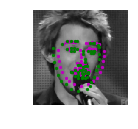

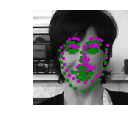

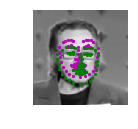

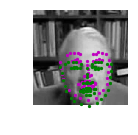

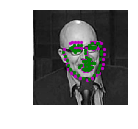

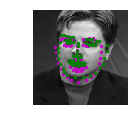

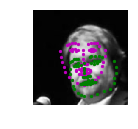

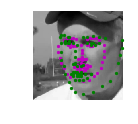

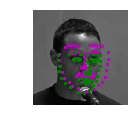

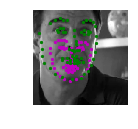

In [24]:
# visualize the test output
visualize_output(test_images, test_outputs, gt_pts)